# Установка зависимостей

In [ ]:
!wget -q zaborshicov.ru/hiden/startup_train.csv
!wget -q zaborshicov.ru/hiden/startup_test.csv

In [ ]:
!pip install optuna
!pip install catboost

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier as kNN
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from matplotlib import pyplot as plt
from sklearn.naive_bayes import CategoricalNB, GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score
import numpy as np
import seaborn as sns
import datetime

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 4.9 MB/s eta 0:00:00


In [ ]:
TRESHOLD_COUNT = 30
TRESHOLD_DELTA = 0.05
y_name = 'has_next_round'
random_state = 1703

**Описание набора данных:**<p>
**Необходимо обучить алгоритм машинного обучения определять, выживет стартап или нет - задача бинарной классификации**

`index` — уникальный id стартапа; <p>
`name` — название стартапа;<p>
`overview` — описание стартапа;<p>
`category_code` — категория, в которой работает стартап;<p>
`tag_list` — список тэгов для стартапа;<p>
`country_code` — страна, в которой зарегистрирован стартап;<p>
`num_prev_rounds` — количество раундов, который к настоящему времени поднял стартап. Раунд — это получение денег от инвесторов;<p>
`has_raised_amount` — получал ли стартап до настоящего момента деньги от инвесторов;<p>
`ln_raised_amount` — логарифм суммы денег, которые стартап получил от инвесторов к настоящему моменту;<p>
`participants` — количество инвесторов, инвестировавших деньги в стартап;<p>
`previous_any_founder_experience` — был ли у основателя стартапа опыт в работе/бизнесе до основания стартапа;<p>
`ipo_prob` — вычисленное Андреем значение вероятности, что в будущем стартап попробует стать публичной компанией;<p>
`ma_prob` — вычисленное Андреем значение, что в будущем стартап будет приобретен другой компанией;<p>
`has_next_round` (целевая переменная) — выживет ли стартап.

# EDA

## Первичный анализ признаков

In [ ]:
df = pd.read_csv('startup_train.csv').drop('index', axis=1)
df_test = pd.read_csv('startup_test.csv').drop('index', axis=1)
# df_concat = pd.concat([df, df_test]).reset_index().drop(['index'], axis=1)
# df_onlynum = df.drop(['name', 'overview', 'category_code', 'tag_list', 'country_code'], axis=1)
# df_onlynum_test = df_test.drop(['name', 'overview', 'category_code', 'tag_list', 'country_code'], axis=1)
df.head()

,name,overview,category_code,tag_list,country_code,num_prev_rounds,has_raised_amount,ln_raised_amount,participants,previous_any_founder_experience,ipo_prob,ma_prob,has_next_round
0,Stackdriver,Stackdriver provides a [powerfully simple moni...,enterprise,"application-management, cloud-monitoring, moni...",USA,1,1,15.424948,1,0,0.024390,0.182927,1
1,Authix Tecnologies,Authix Tecnologies is a Torino based start-up ...,security,authentication-solution,GRC,1,1,13.340052,1,0,0.000000,0.000000,1
2,Lytics,Lytics provides B2C marketers the first analyt...,software,"analytics, big-data, data-science, bigdata",USA,2,1,14.603968,5,0,0.021505,0.242105,0
3,1World Online,1World Online is a Silicon Valley-based startu...,enterprise,"social-research, big-data, analytics, mobile",USA,1,1,13.815511,1,0,0.000000,0.000000,0
4,Enure Networks,"Enure Networks, Ltd. provides home-network man...",software,NaN,ISR,1,1,15.894952,2,0,0.000000,0.000000,1


In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.nunique()

name                               5512
overview                           5510
category_code                        41
tag_list                           3286
country_code                         69
num_prev_rounds                      10
has_raised_amount                     2
ln_raised_amount                   1087
participants                         27
previous_any_founder_experience       2
ipo_prob                            755
ma_prob                            1310
has_next_round                        2
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   name                             5512 non-null   object 
 1   overview                         5510 non-null   object 
 2   category_code                    5512 non-null   object 
 3   tag_list                         3319 non-null   object 
 4   country_code                     5512 non-null   object 
 5   num_prev_rounds                  5512 non-null   int64  
 6   has_raised_amount                5512 non-null   int64  
 7   ln_raised_amount                 5512 non-null   float64
 8   participants                     5512 non-null   int64  
 9   previous_any_founder_experience  5512 non-null   int64  
 10  ipo_prob                         5512 non-null   float64
 11  ma_prob                          5512 non-null   float64
 12  has_next_round      

In [ ]:
df_categorical =  ['name',
                   'overview',
                   'category_code',
                   'tag_list',
                   'country_code'
                   ]
df_numerical = ['num_prev_rounds',
                'ln_raised_amount',
                'participants',
                'ipo_prob',
                'ma_prob'
                ]
df_binary = ['previous_any_founder_experience',
             'has_raised_amount'
             ]

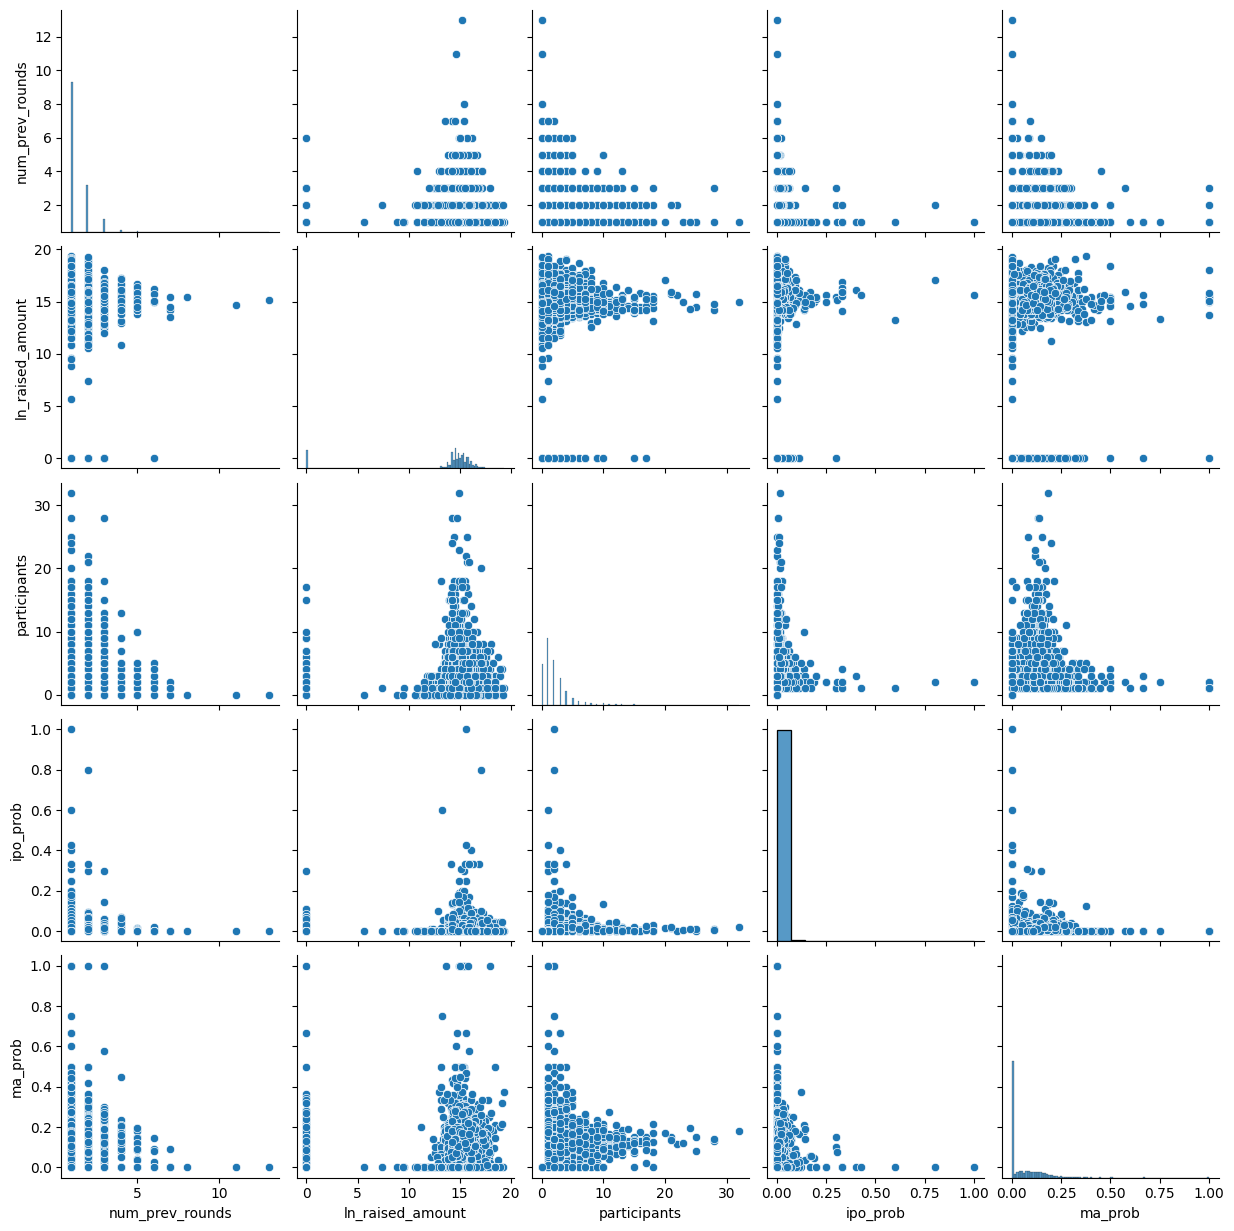

In [ ]:
import seaborn as sns
sns.pairplot(df[df_numerical])

array([[<Axes: title={'center': 'num_prev_rounds'}>,
        <Axes: title={'center': 'ln_raised_amount'}>],
       [<Axes: title={'center': 'participants'}>,
        <Axes: title={'center': 'ipo_prob'}>],
       [<Axes: title={'center': 'ma_prob'}>, <Axes: >]], dtype=object)

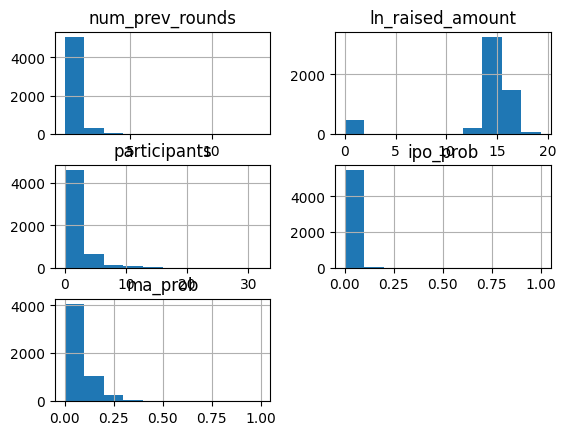

In [ ]:
df[df_numerical].hist()

num_prev_rounds


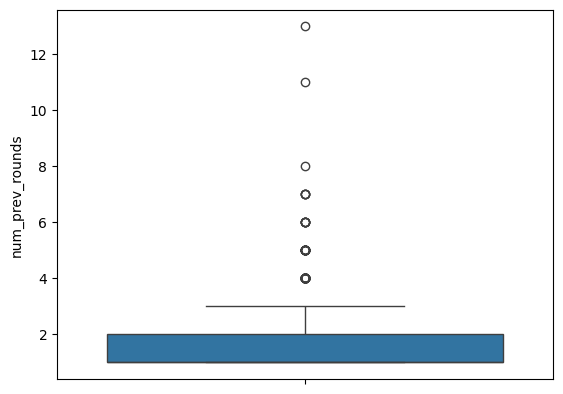

ln_raised_amount


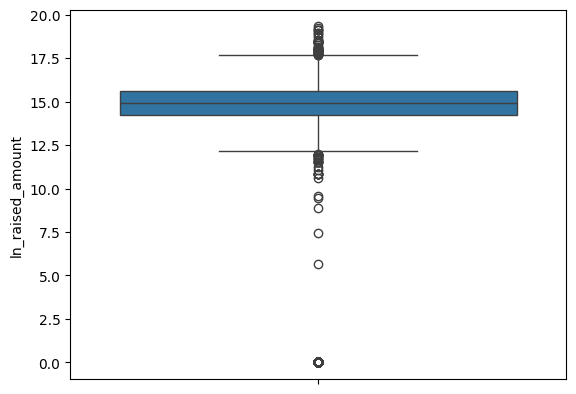

participants


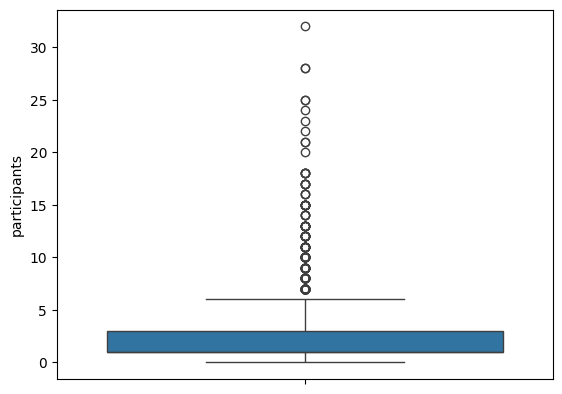

ipo_prob


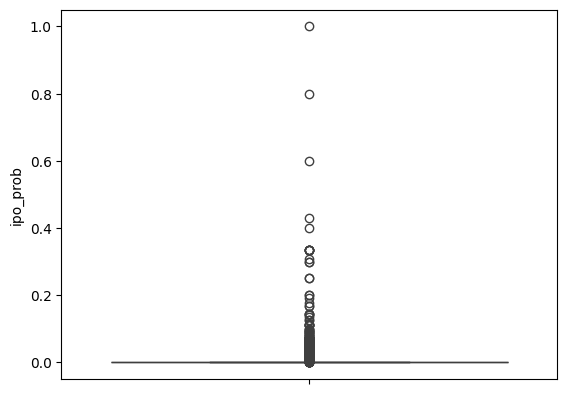

ma_prob


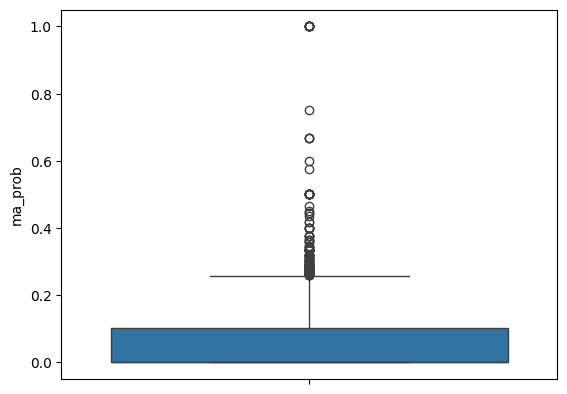

In [ ]:
for col in df_numerical:
    print(col)
    sns.boxplot(df[col])
    plt.show()

Не уверена, есть ли выбросы, т к даже значения, которые сильно отклоняются не выглядят сильно неправдоподобными

### Анализ participants

In [ ]:
df[['participants']].value_counts()

participants
1               1711
2               1149
0               1059
3                690
4                355
5                181
6                109
7                 74
8                 40
10                38
9                 29
11                17
12                12
15                10
13                10
17                 5
18                 5
14                 4
16                 3
21                 2
25                 2
28                 2
20                 1
22                 1
23                 1
24                 1
32                 1
Name: count, dtype: int64

In [ ]:
df.groupby(['participants', 'has_next_round']).agg({'has_next_round': 'count'}).tail(10)

has_next_round
participants has_next_round                
18           1                            1
20           1                            1
21           0                            2
22           0                            1
23           0                            1
24           0                            1
25           0                            2
28           0                            1
             1                            1
32           0                            1

А вот это уже выглядит довольно странно, получается, что при большом количестве инвесторов почти всегда стартап не проходит дальше, отметим 25-32 - выбросом

In [ ]:
df.shape

(5512, 13)

In [ ]:
df = df[df['participants'] < 25]
df.shape

(5507, 13)

### Анализ num_prev_rounds

In [ ]:
df.groupby(['num_prev_rounds', 'has_next_round']).agg({'has_next_round': 'count'})

has_next_round
num_prev_rounds has_next_round                
1               0                         1890
                1                         1979
2               0                          677
                1                          531
3               0                          213
                1                          127
4               0                           33
                1                           18
5               0                           14
                1                           12
6               0                            3
                1                            3
7               0                            3
                1                            1
8               1                            1
11              0                            1
13              1                            1

In [ ]:
df = df[df['num_prev_rounds'] <= 10]
df.shape

(5505, 13)

### Рассмотрим ipo_prob, ma_prob

In [ ]:
df[['ipo_prob', 'ma_prob', 'has_next_round']].corr()

,ipo_prob,ma_prob,has_next_round
ipo_prob,1.000000,0.087640,0.020088
ma_prob,0.087640,1.000000,-0.036611
has_next_round,0.020088,-0.036611,1.000000


In [ ]:
df_check = df[['ipo_prob', 'ma_prob', 'has_next_round']]

In [ ]:
df_check['prod_of_two'] =  np.exp((df_check['ipo_prob']) * (df_check['ma_prob']))
df_check['sum_of_two'] =  (df_check['ipo_prob']) + (df_check['ma_prob'])
# df_check['div_of_two'] =  (df_check['new_ipo_prob']) / (df_check['new_ma_prob'])

<ipython-input-21-d299c827714a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_check['prod_of_two'] =  np.exp((df_check['ipo_prob']) * (df_check['ma_prob']))
<ipython-input-21-d299c827714a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_check['sum_of_two'] =  (df_check['ipo_prob']) + (df_check['ma_prob'])


In [ ]:
df[df['ln_raised_amount'] == 0]['has_next_round'].value_counts(normalize=True)

has_next_round
0    0.66167
1    0.33833
Name: proportion, dtype: float64

Теперь надо посмотреть - сколько пропусков в датасете. Это позволяет понять, как нам надо предобрабатывать данные и в целом взаимодействовать с ними. Как мы видим - пропусков в целом не много, однако часто пропущены тэги.

In [ ]:
df.isna().sum()

name                                  0
overview                              2
category_code                         0
tag_list                           2191
country_code                          0
num_prev_rounds                       0
has_raised_amount                     0
ln_raised_amount                      0
participants                          0
previous_any_founder_experience       0
ipo_prob                              0
ma_prob                               0
has_next_round                        0
dtype: int64

Построим график для проверки крайних значений

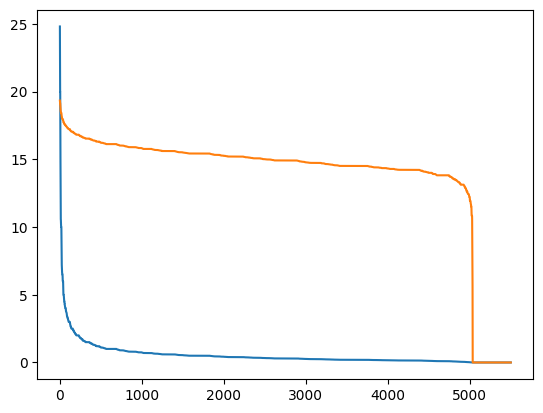

In [ ]:
money = df['ln_raised_amount'].sort_values(ascending=False).reset_index().drop('index', axis=1).values.flatten()
plt.plot(np.exp(money)*1e-7)
plt.plot(money)

In [ ]:
df

,name,overview,category_code,tag_list,country_code,num_prev_rounds,has_raised_amount,ln_raised_amount,participants,previous_any_founder_experience,ipo_prob,ma_prob,has_next_round
0,Stackdriver,Stackdriver provides a [powerfully simple moni...,enterprise,"application-management, cloud-monitoring, moni...",USA,1,1,15.424948,1,0,0.024390,0.182927,1
1,Authix Tecnologies,Authix Tecnologies is a Torino based start-up ...,security,authentication-solution,GRC,1,1,13.340052,1,0,0.000000,0.000000,1
2,Lytics,Lytics provides B2C marketers the first analyt...,software,"analytics, big-data, data-science, bigdata",USA,2,1,14.603968,5,0,0.021505,0.242105,0
3,1World Online,1World Online is a Silicon Valley-based startu...,enterprise,"social-research, big-data, analytics, mobile",USA,1,1,13.815511,1,0,0.000000,0.000000,0
4,Enure Networks,"Enure Networks, Ltd. provides home-network man...",software,NaN,ISR,1,1,15.894952,2,0,0.000000,0.000000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5507,ice,Ice.com is one of the leading e-commerce websi...,ecommerce,"jewelry, ecommerce",USA,1,1,17.665658,1,0,0.000000,0.013889,0
5508,Course Hero,Course Hero is a digital learning platform tha...,education,"social-learning-network, online-courses, onlin...",USA,2,1,14.220976,6,0,0.010811,0.128342,0
5509,DVS Sciences,"DVS Sciences, Inc. manufactures and has global...",manufacturing,NaN,USA,1,1,16.496532,3,0,0.000000,0.106667,0
5510,KAYAK,KAYAK is a travel search engine. It indexes h...,search,"travel, travelsearch, airfare",USA,1,1,15.955577,2,0,0.333333,0.000000,1


# Генерация фичей

In [ ]:
# колонка с количеством тегов + клолнка с отсутствием тегов отдельно
df_extended = df.copy()
df_extended['count_of_tags'] = df.tag_list.str.count(',') + 1
df_extended['count_of_tags'][df.tag_list.isna()] = 0
df_extended['no_tags'] = df['tag_list'].isna()

# пороги денежных масс, вложенных в стартап
df_extended['no_money'] = df['ln_raised_amount'] == 0
df_extended['many_money'] = df['ln_raised_amount'] > money[5000]
df_extended['realy_a_lot_of_money'] = df['ln_raised_amount'] > money[5300]
df_extended['little_money'] = df['ln_raised_amount'] < money[1000]
df_extended['little_money'] = df['ln_raised_amount'] < money[1000]
df_extended['too_little_money'] = df['ln_raised_amount'] < money[750]

# длина описания
df_extended['overview_length'] = df.overview.str.count(' ') + 1
df_extended['overview_length'][df.overview.isna()] = 0
df_extended['small_length'] = df_extended['overview_length'] < 20
df_extended['large_length'] = df_extended['overview_length'] > 200
df_extended['too_large_length'] = df_extended['overview_length'] > 300

# сколько в среднем вложился 1 учасник
df_extended['ln_raised_amount/participants'] = np.exp(df_extended['ln_raised_amount'])/(df_extended['participants'] + 1)

df_extended['no_invest'] = df['participants'] == 0
df_extended['len'] = df.name.str.len()
df_extended['tooshort'] = df_extended['len'] <= 2
df_extended['short'] = df_extended['len'] <= 5
df_extended['numinname'] = df['name'].str.extract('(\d+)').isna()
df_extended['large'] = df_extended['len'] >= 10
df_extended['toolarge'] = df_extended['len'] >= 25

# признаки, полученные ранее
df_extended['ipo_ma_prob_sum'] = df['ipo_prob'] - df['ma_prob']
df_extended['ipo_ma_prob_prod'] = df['ipo_prob'] * df['ma_prob']

df_extended.head()

<ipython-input-28-4e3a2c4332a9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extended['count_of_tags'][df.tag_list.isna()] = 0
<ipython-input-28-4e3a2c4332a9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extended['overview_length'][df.overview.isna()] = 0


,name,overview,category_code,tag_list,country_code,num_prev_rounds,has_raised_amount,ln_raised_amount,participants,previous_any_founder_experience,...,ln_raised_amount/participants,no_invest,len,tooshort,short,numinname,large,toolarge,ipo_ma_prob_sum,ipo_ma_prob_prod
0,Stackdriver,Stackdriver provides a [powerfully simple moni...,enterprise,"application-management, cloud-monitoring, moni...",USA,1,1,15.424948,1,0,...,2.500000e+06,False,11,False,False,True,True,False,-0.158537,0.004462
1,Authix Tecnologies,Authix Tecnologies is a Torino based start-up ...,security,authentication-solution,GRC,1,1,13.340052,1,0,...,3.108000e+05,False,18,False,False,True,True,False,0.000000,0.000000
2,Lytics,Lytics provides B2C marketers the first analyt...,software,"analytics, big-data, data-science, bigdata",USA,2,1,14.603968,5,0,...,3.666667e+05,False,6,False,False,True,False,False,-0.220600,0.005207
3,1World Online,1World Online is a Silicon Valley-based startu...,enterprise,"social-research, big-data, analytics, mobile",USA,1,1,13.815511,1,0,...,5.000000e+05,False,13,False,False,False,True,False,0.000000,0.000000
4,Enure Networks,"Enure Networks, Ltd. provides home-network man...",software,NaN,ISR,1,1,15.894952,2,0,...,2.666667e+06,False,14,False,False,True,True,False,0.000000,0.000000


In [ ]:
df_extended_test = df_test.copy()
df_extended_test['count_of_tags'] = df_test.tag_list.str.count(',') + 1
df_extended_test['count_of_tags'][df_test.tag_list.isna()] = 0
df_extended_test['no_tags'] = df_test['tag_list'].isna()

df_extended_test['no_money'] = df_test['ln_raised_amount'] == 0
df_extended_test['many_money'] = df_test['ln_raised_amount'] > money[5000]
df_extended_test['realy_a_lot_of_money'] = df_test['ln_raised_amount'] > money[5300]
df_extended_test['little_money'] = df_test['ln_raised_amount'] < money[1000]
df_extended_test['little_money'] = df_test['ln_raised_amount'] < money[1000]
df_extended_test['too_little_money'] = df_test['ln_raised_amount'] < money[750]

df_extended_test['overview_length'] = df_test.overview.str.count(' ') + 1
df_extended_test['overview_length'][df_test.overview.isna()] = 0
df_extended_test['small_length'] = df_extended_test['overview_length'] < 20
df_extended_test['large_length'] = df_extended_test['overview_length'] > 200
df_extended_test['too_large_length'] = df_extended_test['overview_length'] > 300

df_extended_test['ln_raised_amount/participants'] = df_extended_test['ln_raised_amount']/(df_extended_test['participants'] + 1)

df_extended_test['no_invest'] = df_test['participants'] == 0
df_extended_test['len'] = df_test.name.str.len()
df_extended_test['tooshort'] = df_extended_test['len'] <= 2
df_extended_test['short'] = df_extended_test['len'] <= 5
df_extended_test['numinname'] = df_test['name'].str.extract('(\d+)').isna()
df_extended_test['large'] = df_extended_test['len'] >= 10
df_extended_test['toolarge'] = df_extended_test['len'] >= 25

df_extended_test['ipo_ma_prob_sum'] = df['ipo_prob'] - df['ma_prob']
df_extended_test['ipo_ma_prob_prod'] = df['ipo_prob'] * df['ma_prob']
df_extended_test.shape

<ipython-input-29-7cb37a09a1bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extended_test['count_of_tags'][df_test.tag_list.isna()] = 0
<ipython-input-29-7cb37a09a1bc>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_extended_test['overview_length'][df_test.overview.isna()] = 0


(1378, 33)

In [ ]:
df_extended_num = df_extended.select_dtypes(exclude=['object']).columns
df_extended_num

Index(['num_prev_rounds', 'has_raised_amount', 'ln_raised_amount',
       'participants', 'previous_any_founder_experience', 'ipo_prob',
       'ma_prob', 'has_next_round', 'count_of_tags', 'no_tags', 'no_money',
       'many_money', 'realy_a_lot_of_money', 'little_money',
       'too_little_money', 'overview_length', 'small_length', 'large_length',
       'too_large_length', 'ln_raised_amount/participants', 'no_invest', 'len',
       'tooshort', 'short', 'numinname', 'large', 'toolarge',
       'ipo_ma_prob_sum', 'ipo_ma_prob_prod'],
      dtype='object')

<Axes: >

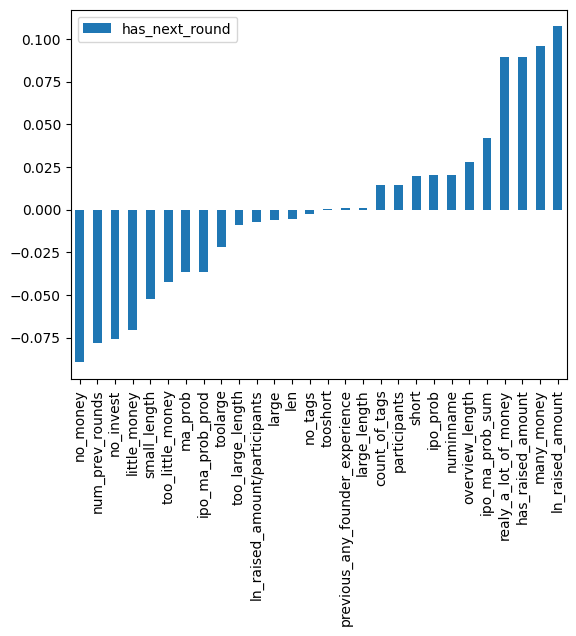

In [ ]:
df_extended[df_extended_num].corr()[['has_next_round']].drop('has_next_round').sort_values(by='has_next_round').plot.bar()

<Axes: >

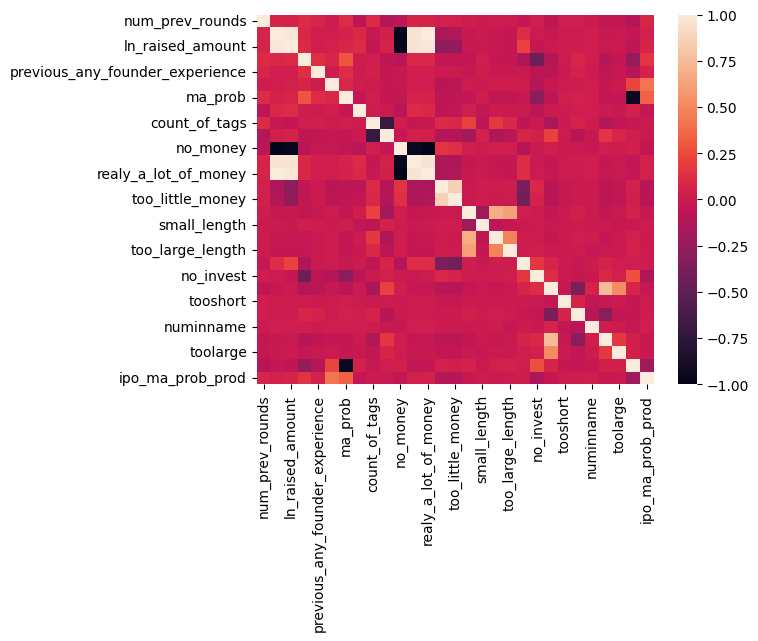

In [ ]:
sns.heatmap(df_extended[df_extended_num].corr())

# Базовые модели



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_extended.drop(y_name, axis=1), df_extended.has_next_round, test_size=0.25, random_state=random_state)

In [ ]:
df_extended['overview'] = df_extended['overview'].apply(str)
df_extended['name'] = df_extended['name'].apply(str)
df_extended['tag_list'] = df_extended['tag_list'].apply(str)

In [ ]:
from sklearn.model_selection import cross_val_score

df_text =  ['name', 'overview', 'tag_list']
df_cat = ['category_code', 'country_code']

In [ ]:
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
# X_train, X_test, y_train, y_test = train_test_split(ohe_df.drop(y_name, axis=1), df_extended[y_name], test_size=0.25, random_state=random_state)
def objective_catboost(trial):
    param = {
        "depth": trial.suggest_int("depth", 2, 10),
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 2, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.01),
        'random_strength': trial.suggest_int('random_strength', 0, 10),
        # 'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        # 'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        # 'max_leaves': trial.suggest_int('max_leaves', 31, 128),
        # 'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        # 'od_wait': trial.suggest_int('od_wait', 10, 50)
    }

    estimator = CatBoostClassifier(**param, random_state=random_state, cat_features=df_cat, text_features=df_text, verbose=False, task_type='GPU')

    # score = cross_val_score(estimator, X_train, y_train, cv=3, scoring='accuracy', verbose=2).mean()
    estimator.fit(X_train, y_train)
    score = accuracy_score(y_test, estimator.predict(X_test))
    return score


study = optuna.create_study(direction="maximize")
study.optimize(objective_catboost, n_trials=30)
study.best_trial

[I 2024-07-19 10:42:43,284] A new study created in memory with name: no-name-59c53dd8-1438-4361-98a4-b9fa47894d79
[I 2024-07-19 10:43:18,297] Trial 0 finished with value: 0.6049382716049383 and parameters: {'depth': 6, 'iterations': 720, 'l2_leaf_reg': 2, 'learning_rate': 0.0027459890916229504, 'random_strength': 6, 'bagging_temperature': 0.1898399649279049}. Best is trial 0 with value: 0.6049382716049383.
[I 2024-07-19 10:43:41,639] Trial 1 finished with value: 0.6092955700798838 and parameters: {'depth': 4, 'iterations': 946, 'l2_leaf_reg': 7, 'learning_rate': 0.008173632189754244, 'random_strength': 10, 'bagging_temperature': 0.06466169904125518}. Best is trial 1 with value: 0.6092955700798838.
[I 2024-07-19 10:44:14,761] Trial 2 finished with value: 0.6230936819172114 and parameters: {'depth': 10, 'iterations': 425, 'l2_leaf_reg': 10, 'learning_rate': 0.007139121465941843, 'random_strength': 5, 'bagging_temperature': 0.19998408019430525}. Best is trial 2 with value: 0.6230936819172

FrozenTrial(number=13, state=TrialState.COMPLETE, values=[0.6245461147421931], datetime_start=datetime.datetime(2024, 7, 19, 10, 54, 7, 578075), datetime_complete=datetime.datetime(2024, 7, 19, 10, 55, 54, 107271), params={'depth': 9, 'iterations': 686, 'l2_leaf_reg': 7, 'learning_rate': 0.006780210098396745, 'random_strength': 2, 'bagging_temperature': 0.3414749630464896}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'depth': IntDistribution(high=10, log=False, low=2, step=1), 'iterations': IntDistribution(high=1000, log=False, low=100, step=1), 'l2_leaf_reg': IntDistribution(high=10, log=False, low=2, step=1), 'learning_rate': FloatDistribution(high=0.01, log=False, low=0.001, step=None), 'random_strength': IntDistribution(high=10, log=False, low=0, step=1), 'bagging_temperature': FloatDistribution(high=1.0, log=False, low=0.0, step=None)}, trial_id=13, value=None)

In [ ]:
model_cb = CatBoostClassifier(**study.best_params, random_state=random_state, cat_features=df_cat, text_features=df_text)
model_cb.fit(df_extended.drop(y_name, axis=1), df_extended.has_next_round)

0:	learn: 0.6929511	total: 2.38s	remaining: 27m 13s
1:	learn: 0.6927861	total: 4.85s	remaining: 27m 37s
2:	learn: 0.6925296	total: 7.41s	remaining: 28m 7s
3:	learn: 0.6922584	total: 10.9s	remaining: 31m 1s
4:	learn: 0.6920111	total: 13.5s	remaining: 30m 36s
5:	learn: 0.6916975	total: 15.9s	remaining: 30m 1s
6:	learn: 0.6913521	total: 18.3s	remaining: 29m 38s
7:	learn: 0.6909813	total: 20.9s	remaining: 29m 32s
8:	learn: 0.6906707	total: 24.3s	remaining: 30m 26s
9:	learn: 0.6904632	total: 26.7s	remaining: 30m 3s
10:	learn: 0.6901346	total: 29.1s	remaining: 29m 47s
11:	learn: 0.6895618	total: 31.6s	remaining: 29m 35s
12:	learn: 0.6893265	total: 34.2s	remaining: 29m 31s
13:	learn: 0.6890365	total: 37.5s	remaining: 30m 1s
14:	learn: 0.6889486	total: 39.9s	remaining: 29m 44s
15:	learn: 0.6886884	total: 42.3s	remaining: 29m 31s
16:	learn: 0.6884769	total: 44.7s	remaining: 29m 20s
17:	learn: 0.6882481	total: 47.3s	remaining: 29m 14s
18:	learn: 0.6878589	total: 50.7s	remaining: 29m 41s
19:	lear

In [ ]:
pd.DataFrame(model_cb.feature_importances_, df_extended.drop('has_next_round', axis=1).columns).sort_values(by=0, ascending=False)

,0
overview,46.444948
country_code,18.427806
ln_raised_amount,9.161306
ma_prob,4.759672
participants,4.049650
category_code,3.234034
num_prev_rounds,3.171040
ipo_ma_prob_sum,2.470911
ln_raised_amount/participants,2.296051
tag_list,1.582412


In [ ]:
df_extended_new = df_extended.drop(columns=['large_length','previous_any_founder_experience', 'tooshort'], axis=1)

In [ ]:
model_cb.fit(df_extended_new.drop(y_name, axis=1), df_extended_new.has_next_round)

0:	learn: 0.6928774	total: 3.67s	remaining: 41m 54s
1:	learn: 0.6926798	total: 6.11s	remaining: 34m 51s
2:	learn: 0.6924126	total: 8.6s	remaining: 32m 37s
3:	learn: 0.6923672	total: 11.1s	remaining: 31m 33s
4:	learn: 0.6921075	total: 13.8s	remaining: 31m 18s
5:	learn: 0.6918832	total: 17.2s	remaining: 32m 32s
6:	learn: 0.6916846	total: 19.7s	remaining: 31m 53s
7:	learn: 0.6915351	total: 22.2s	remaining: 31m 23s
8:	learn: 0.6910790	total: 24.7s	remaining: 30m 59s
9:	learn: 0.6907963	total: 27.5s	remaining: 31m
10:	learn: 0.6904481	total: 31s	remaining: 31m 39s
11:	learn: 0.6900857	total: 33.5s	remaining: 31m 20s
12:	learn: 0.6897969	total: 36s	remaining: 31m 2s
13:	learn: 0.6895824	total: 38.5s	remaining: 30m 46s
14:	learn: 0.6893023	total: 41.3s	remaining: 30m 48s
15:	learn: 0.6890449	total: 44.7s	remaining: 31m 11s
16:	learn: 0.6887349	total: 47.2s	remaining: 30m 57s
17:	learn: 0.6883706	total: 49.7s	remaining: 30m 43s
18:	learn: 0.6880125	total: 52.1s	remaining: 30m 30s
19:	learn: 0.

In [ ]:
df_extended_test['overview'] = df_extended_test['overview'].apply(str)
df_extended_test['name'] = df_extended_test['name'].apply(str)
df_extended_test['tag_list'] = df_extended_test['tag_list'].apply(str)

In [ ]:
df_extended_test_new = df_extended_test.drop(columns=['large_length','previous_any_founder_experience', 'tooshort'], axis=1)

In [ ]:
pred = model_cb.predict(df_extended_test_new)